### The purpose of this notebook to is to recreate the regress the SSH in GLORYS onto the CWI developed in Amaya et al. (2022)

In [33]:
INDEX_TYPE = "RMM"

In [34]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/scripts')
plotsdir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/plots/" + x
GLORYS_dir = lambda x="": "/vortexfs1/home/anthony.meza/GLORYS_data" + x
GLORYS_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/GLORYS_processed/" + x
ERA5_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/ERA5_data/" + x

In [35]:
# from help_funcs import * 
# from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import importlib
import xarray as xr
import seaborn as sns
import pandas as pd
import cmocean.cm as cm
import netCDF4 as nc
from pathlib import Path
import matplotlib.pyplot as plt
import gc
from multiprocessing import Pool
import os 
import multiprocessing
from os.path import exists
import dask_labextension
from pathlib import Path
import numpy as np
import dask
from multipledispatch import dispatch
sns.set_context("talk")

In [36]:
@dispatch(object, object)
def prepare_IVTE_and_IVTN(DJF_phases, phase):
    IVT = xr.merge([DJF_phases["IVTE"][phase], DJF_phases["IVTN"][phase]]).sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80))
    IVT = IVT.isel(longitude = slice(0, None, 16), latitude =  slice(0, None, 14))
    IVT["IVT"] = np.sqrt(IVT["IVTE"]**2 + IVT["IVTN"]**2)
    IVT["IVT"].attrs["units"] = "(kg m)/s "
    return IVT 
@dispatch(object)
def prepare_IVTE_and_IVTN(DJF_phase):
    IVT = xr.merge([DJF_phase["IVTE"], DJF_phase["IVTN"]]).sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80))
    IVT = IVT.isel(longitude = slice(0, None, 16), latitude =  slice(0, None, 14))
    IVT["IVT"] = np.sqrt(IVT["IVTE"]**2 + IVT["IVTN"]**2)
    IVT["IVT"].attrs["units"] = "(kg m)/s "
    return IVT 

In [37]:
def combine_phases(var_phases, phases_dict):
    d = dict()
    ndays = dict()
    nphase_indices1 = len(phases_dict["1"])
    nphase_indices2 = len(phases_dict["8"])
    ndays["18"] = nphase_indices1 + nphase_indices2
    d["18"] = (var_phases["1"]*nphase_indices1 + var_phases["8"]*nphase_indices2) / ndays["18"]
    
    nphase_indices1 = len(phases_dict["2"])
    nphase_indices2 = len(phases_dict["3"])
    ndays["23"] = nphase_indices1 + nphase_indices2
    d["23"] = (var_phases["2"]*nphase_indices1 + var_phases["3"]*nphase_indices2) / ndays["23"]
      
    nphase_indices1 = len(phases_dict["4"])
    nphase_indices2 = len(phases_dict["5"])
    ndays["45"] = nphase_indices1 + nphase_indices2

    d["45"] = (var_phases["4"]*nphase_indices1 + var_phases["5"]*nphase_indices2) / ndays["45"]
    
    nphase_indices1 = len(phases_dict["6"])
    nphase_indices2 = len(phases_dict["7"])
    ndays["67"] = nphase_indices1 + nphase_indices2
    d["67"] = (var_phases["6"]*nphase_indices1 + var_phases["7"]*nphase_indices2) / ndays["67"]
    
    return d, ndays

### We read in the Amaya Coastal Wave Index Amplitude $(\text{Index} =  \sqrt{\text{PC1}^2 + \text{PC2}^2)}$ and Phase $(\text{Phase} = atan( {\frac{\text{PC2}}{\text{PC1}}}))$ and recompute $\text{PC1}$ and $\text{PC2}$. We also remove the leap-year days from the GLORYS dataset.

In [38]:
# Store data (serialize)
indexdir = INDEX_TYPE + "_Phases"

import pickle
with open(GLORYS_data_dir(INDEX_TYPE + "_Phases/Composites.pickle"), 'rb') as handle:
    DJF_phases = pickle.load(handle)
# Store data (serialize)
with open(GLORYS_data_dir(INDEX_TYPE + "_Phases/CompositesPhase4.pickle"), 'rb') as handle:
    DJF_phase4_dict = pickle.load(handle)
# Store data (serialize)
with open(GLORYS_data_dir(INDEX_TYPE + "_Phases/IndexPhases.pickle"), 'rb') as handle:
    phases_dict = pickle.load(handle)

In [39]:
combine_DJF_phases = dict()
combine_DJF_phases_days = dict()

for key in DJF_phases.keys():
    temp1, temp2 = combine_phases(DJF_phases[key], phases_dict)
    combine_DJF_phases[key] = temp1
    combine_DJF_phases_days[key] = temp2

## Overlaying the TCWV height anomaly contours on SST 

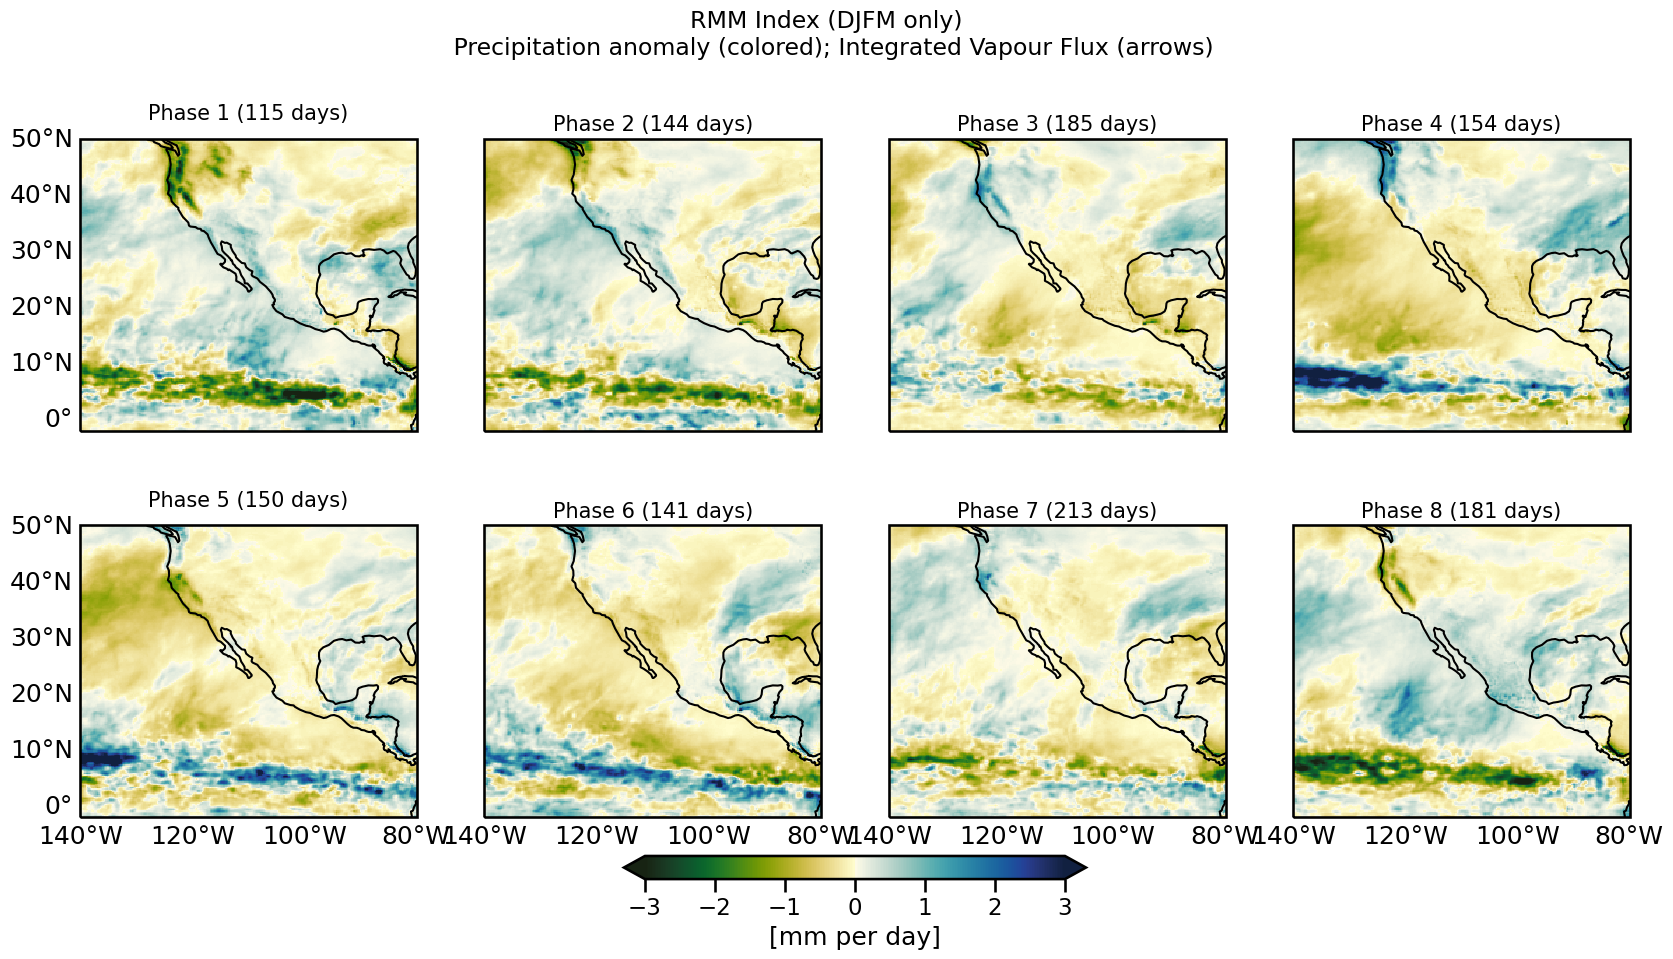

In [43]:
fig, axes = plt.subplots(ncols = 4, nrows = 2, figsize = (20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
z500_levels = np.arange(-0.4, 0.41, 0.1) 
# fig.tight_layout()

fig.suptitle("RMM Index (DJFM only) \n Precipitation anomaly (colored); Integrated Vapour Flux (arrows)", fontsize = 17)

for phase, phase_indices in phases_dict.items():
    phase_num = int(phase) - 1; i = phase_num
    ax = axes.flatten(order = "C")[phase_num]

    if phase != "8":
        IVT = prepare_IVTE_and_IVTN(DJF_phases, phase)
        DJF_phases["Precip"][phase].sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80)).plot(ax = ax, cmap = cm.delta_r,transform = ccrs.PlateCarree(),
                                                                                              vmin = -3, vmax = 3, add_colorbar = False)

        ax.set_title("Phase " + str(phase_num+1) + " (" + str(len(phases_dict[str(i+1)])) + " days)", fontsize = 15)

        # ax.clabel(cs, inline=True, fontsize=10)
    else:
        IVT = prepare_IVTE_and_IVTN(DJF_phases, phase)
    
        DJF_phases["Precip"][phase].sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80)).plot(ax = ax, cmap = cm.delta_r,transform = ccrs.PlateCarree(),
                                                                                              vmin = -3, vmax = 3, add_colorbar = True,zorder=0, 
                                                                                               cbar_kwargs = {"label":"[mm per day]", "extend": "both", 
                                                                                                              "orientation":"horizontal", "ax":axes,
                                                                                                             "fraction":0.03, "pad":0.05})

        
        ax.set_title("Phase " + str(phase_num+1) + " (" + str(len(phases_dict[str(i+1)])) + " days)", fontsize = 15)

for (i, ax) in enumerate(axes[:, 0].flatten()):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.0, linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    
    
for (i, ax) in enumerate(axes[1, :].flatten()):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.0, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
[ax.coastlines() for ax in axes.flatten()];

    
fig.savefig(plotsdir(INDEX_TYPE + "_Index_Precip_IVT_CompositesDJF.png"), bbox_inches = "tight")

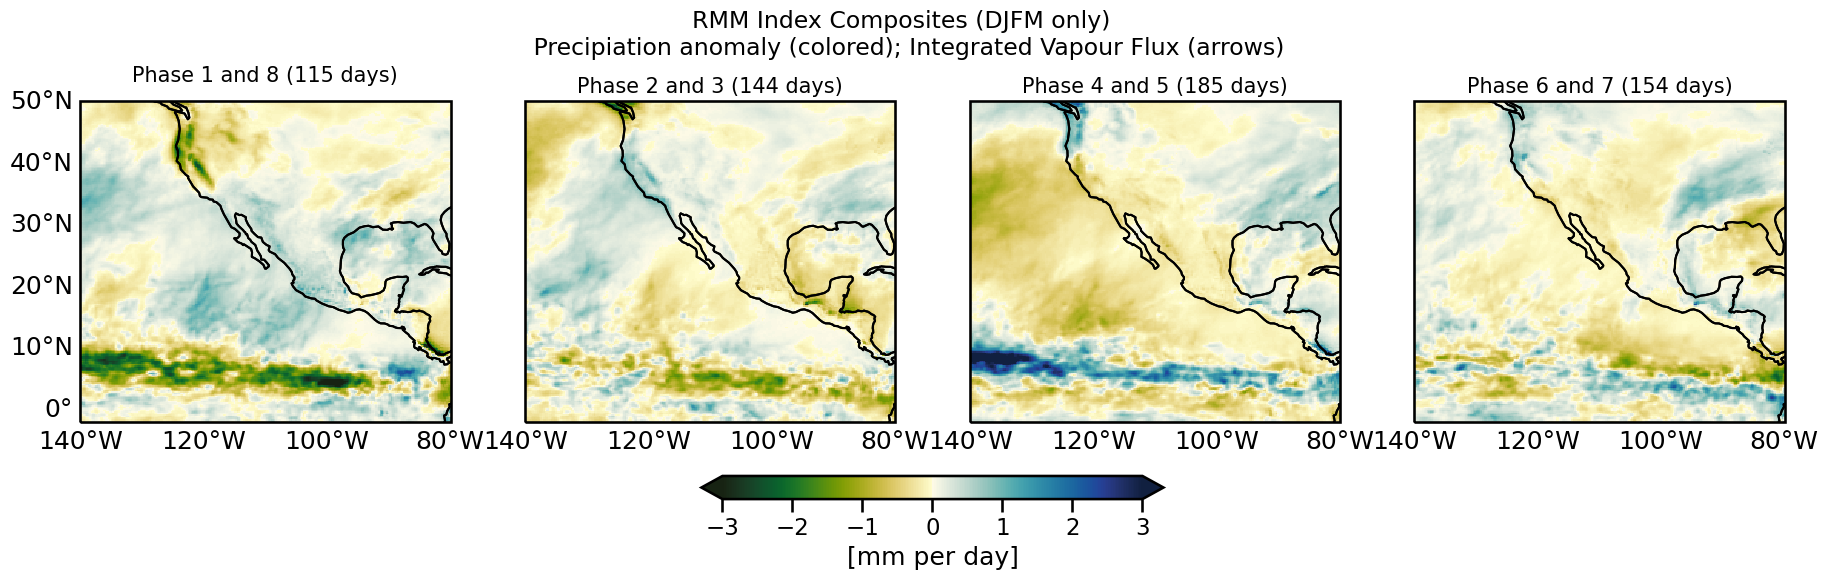

In [42]:
fig, axes = plt.subplots(ncols = 4, nrows = 1, figsize = (22, 10), subplot_kw={'projection': ccrs.PlateCarree()})
z500_levels = np.arange(-0.4, 0.41, 0.1) 
# fig.tight_layout()
[ax.coastlines() for ax in axes.flatten()];

fig.suptitle("RMM Index Composites (DJFM only) \n Precipiation anomaly (colored); Integrated Vapour Flux (arrows)", fontsize = 17, y = 0.6)
labels = ["1 and 8", "2 and 3", "4 and 5", "6 and 7"]
ax = axes[0]
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.0, linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
    
    
for (i, ax) in enumerate(axes[:].flatten()):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.0, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    
for (i, phase) in enumerate(["18", "23", "45", "67"]):
    # phase_num = int(phase) - 1; i = phase_num
    ax = axes.flatten(order = "C")[i]
    IVT = prepare_IVTE_and_IVTN(combine_DJF_phases, phase)

    if phase != "67":
        IVT = prepare_IVTE_and_IVTN(combine_DJF_phases, phase)
        combine_DJF_phases["Precip"][phase].sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80)).plot(ax = ax, cmap = cm.delta_r,transform = ccrs.PlateCarree(),
                                                                                              vmin = -3, vmax = 3, add_colorbar = False)

        ax.set_title("Phase " + labels[i] + " (" + str(len(phases_dict[str(i+1)])) + " days)", fontsize = 15)

        # ax.clabel(cs, inline=True, fontsize=10)
    else:
        IVT = prepare_IVTE_and_IVTN(combine_DJF_phases, phase)
        combine_DJF_phases["Precip"][phase].sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80)).plot(ax = ax, cmap = cm.delta_r,transform = ccrs.PlateCarree(),
                                                                                              vmin = -3, vmax = 3, add_colorbar = True,zorder=0, 
                                                                                               cbar_kwargs = {"label":"[mm per day]", "extend": "both", 
                                                                                                              "orientation":"horizontal", "ax":axes,
                                                                                                             "fraction":0.03, "pad":0.07})

        
        ax.set_title("Phase " + labels[i] + " (" + str(len(phases_dict[str(i+1)])) + " days)", fontsize = 15)


[ax.coastlines() for ax in axes.flatten()];

    
# fig.savefig(plotsdir(INDEX_TYPE + "_Index_Precip_IVT_CompositesDJF.png"), bbox_inches = "tight")

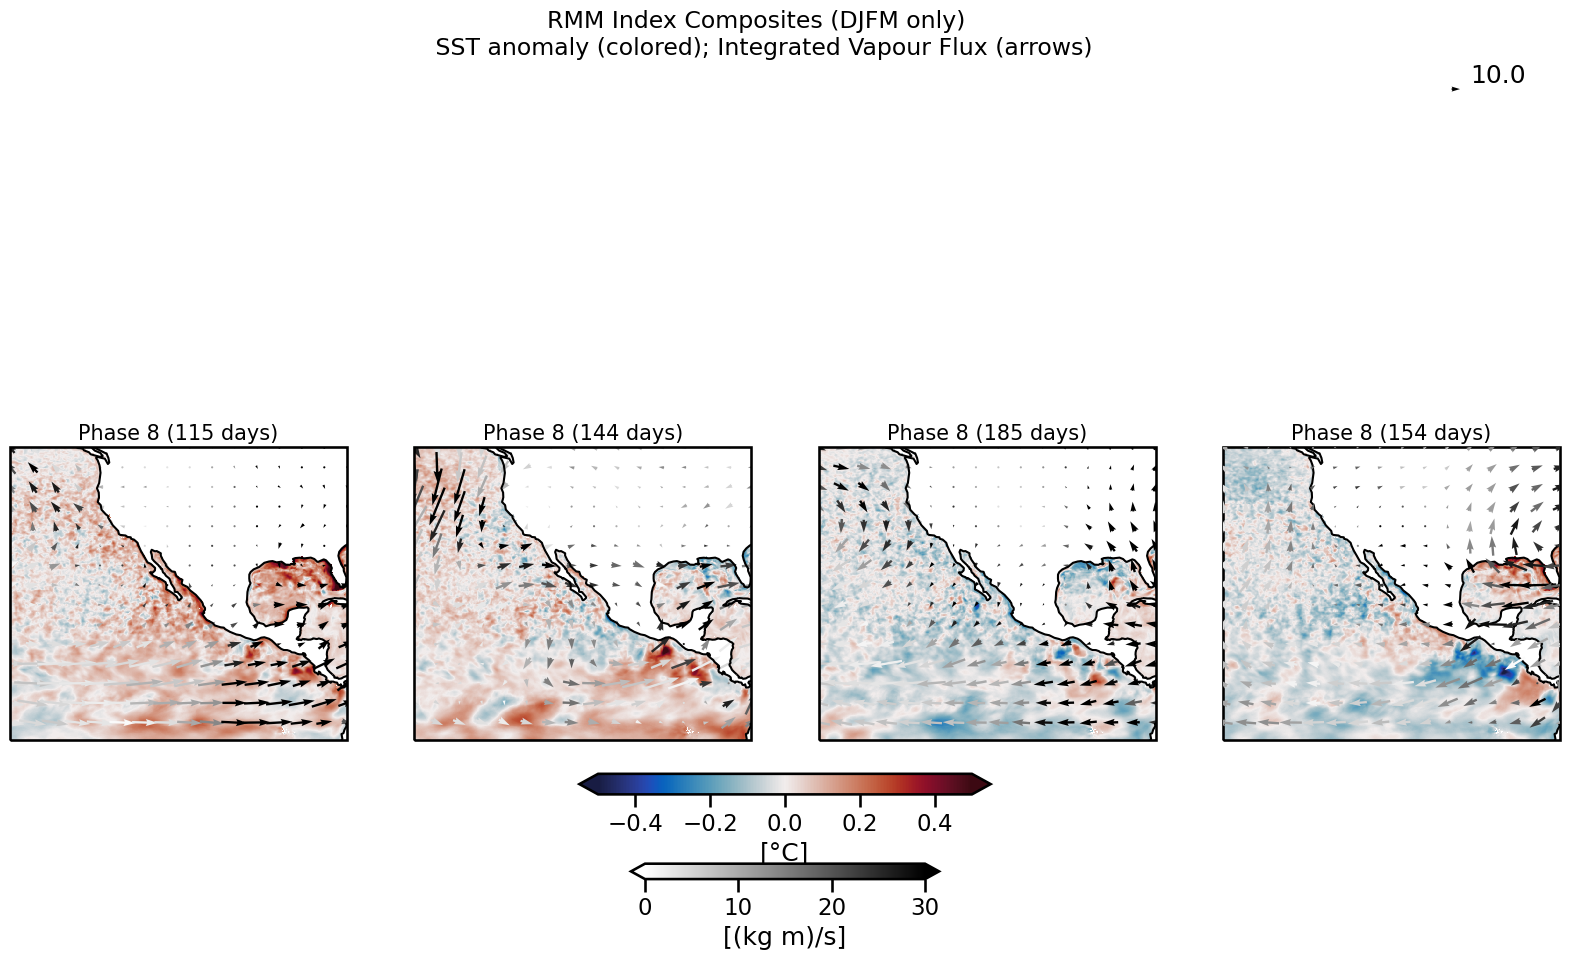

In [29]:
fig, axes = plt.subplots(ncols = 4, nrows = 1, figsize = (20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
z500_levels = np.arange(-0.4, 0.41, 0.1) 
# fig.tight_layout()
[ax.coastlines() for ax in axes.flatten()];

fig.suptitle("RMM Index Composites (DJFM only) \n SST anomaly (colored); Integrated Vapour Flux (arrows)", fontsize = 17)

for (i, phase) in enumerate(["18", "23", "45", "67"]):
    # phase_num = int(phase) - 1; i = phase_num
    ax = axes.flatten(order = "C")[i]
    IVT = prepare_IVTE_and_IVTN(combine_DJF_phases, phase)

    if phase != "67":
        combine_DJF_phases["SST"][phase].sel(latitude = slice(-2, 50), longitude = slice(-140, -80)).plot(ax = ax, cmap = cm.balance,transform = ccrs.PlateCarree(),
                                                                                              vmin = -0.5, vmax = 0.5, add_colorbar = False)
        IVT.plot.quiver(ax = ax, x = "longitude", y = "latitude",u = "IVTE", v = "IVTN", hue = "IVT", transform=ccrs.PlateCarree(),
                    add_guide = False, cmap = "gist_yarg", width = 0.007, vmin = 0, vmax = 30)

        ax.set_title("Phase " + phase + " (" + str(len(phases_dict[str(i+1)])) + " days)", fontsize = 15)

        # ax.clabel(cs, inline=True, fontsize=10)
    else:
        IVT.plot.quiver(ax = ax, x = "longitude", y = "latitude",u = "IVTE", v = "IVTN", hue = "IVT", transform=ccrs.PlateCarree(),
                    add_guide = True, cmap = "gist_yarg", width = 0.007, vmin = 0, vmax = 30, zorder=10, 
                    cbar_kwargs = {"label":"[(kg m)/s]", "extend": "both",  "orientation":"horizontal", "ax":axes, "fraction":0.02, "pad":0.09})
        combine_DJF_phases["SST"][phase].sel(latitude = slice(-2, 50), longitude = slice(-140, -80)).plot(ax = ax, cmap = cm.balance,transform = ccrs.PlateCarree(),
                                                                                              vmin = -0.5, vmax = 0.5, add_colorbar = True,zorder=0,
                                                                                               cbar_kwargs = {"label":"[°C]", "extend": "both", 
                                                                                                              "orientation":"horizontal", "ax":axes,
                                                                                                             "fraction":0.03, "pad":0.05})

        
        ax.set_title("Phase " + str(phase_num+1) + " (" + str(len(phases_dict[str(i+1)])) + " days)", fontsize = 15)
        # ax.clabel(cs, inline=True, fontsize=10)

# for (i, ax) in enumerate(axes[:, 0].flatten()):
#     gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                       linewidth=1, color='gray', alpha=0.0, linestyle='--')
#     gl.top_labels = False
#     gl.bottom_labels = False
#     gl.right_labels = False
    
    
# for (i, ax) in enumerate(axes[1, :].flatten()):
#     gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                       linewidth=1, color='gray', alpha=0.0, linestyle='--')
#     gl.top_labels = False
#     gl.right_labels = False
#     gl.left_labels = False

    
# fig.savefig(plotsdir(INDEX_TYPE + "_Index_SST_IVT_CompositesDJF.png"), bbox_inches = "tight")

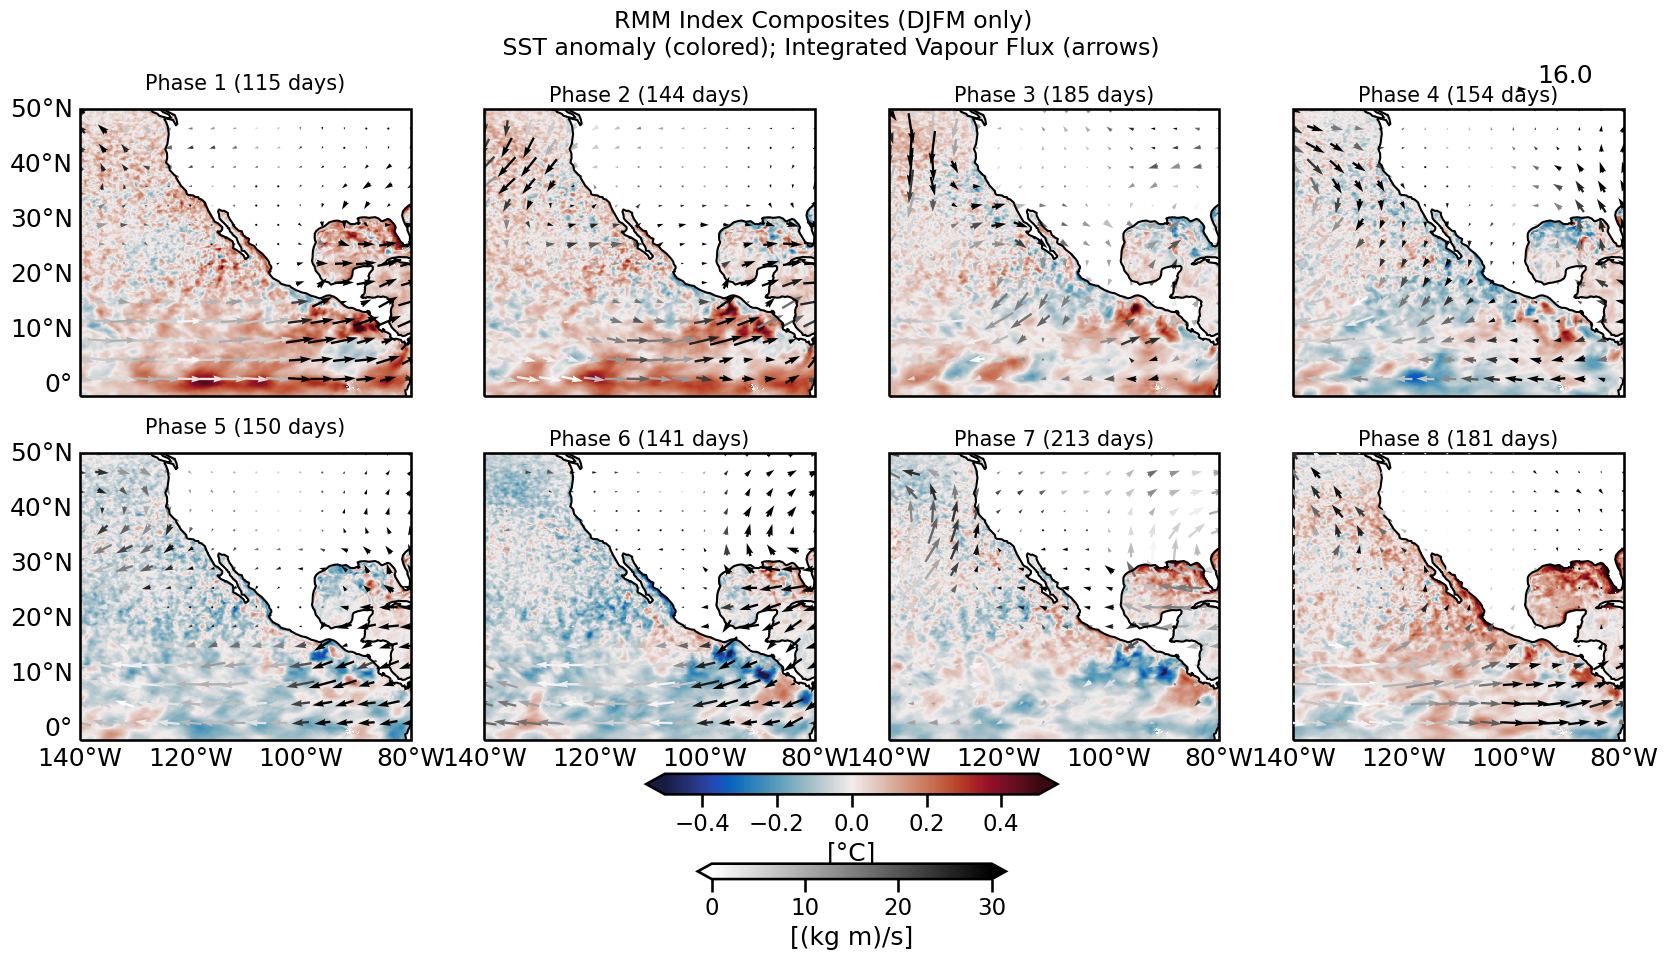

In [7]:
fig, axes = plt.subplots(ncols = 4, nrows = 2, figsize = (20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
z500_levels = np.arange(-0.4, 0.41, 0.1) 
# fig.tight_layout()
[ax.coastlines() for ax in axes.flatten()];

fig.suptitle("RMM Index Composites (DJFM only) \n SST anomaly (colored); Integrated Vapour Flux (arrows)", fontsize = 17)

for phase, phase_indices in phases_dict.items():
    phase_num = int(phase) - 1; i = phase_num
    ax = axes.flatten(order = "C")[phase_num]
    IVT = prepare_IVTE_and_IVTN(DJF_phases, phase)

    if phase != "8":
        DJF_phases["SST"][phase].sel(latitude = slice(-2, 50), longitude = slice(-140, -80)).plot(ax = ax, cmap = cm.balance,transform = ccrs.PlateCarree(),
                                                                                              vmin = -0.5, vmax = 0.5, add_colorbar = False)
        IVT.plot.quiver(ax = ax, x = "longitude", y = "latitude",u = "IVTE", v = "IVTN", hue = "IVT", transform=ccrs.PlateCarree(),
                    add_guide = False, cmap = "gist_yarg", width = 0.007, vmin = 0, vmax = 30)

        ax.set_title("Phase " + str(phase_num+1) + " (" + str(len(phases_dict[str(i+1)])) + " days)", fontsize = 15)

        # ax.clabel(cs, inline=True, fontsize=10)
    else:
        IVT.plot.quiver(ax = ax, x = "longitude", y = "latitude",u = "IVTE", v = "IVTN", hue = "IVT", transform=ccrs.PlateCarree(),
                    add_guide = True, cmap = "gist_yarg", width = 0.007, vmin = 0, vmax = 30, zorder=10, 
                    cbar_kwargs = {"label":"[(kg m)/s]", "extend": "both",  "orientation":"horizontal", "ax":axes, "fraction":0.02, "pad":0.09})
        DJF_phases["SST"][phase].sel(latitude = slice(-2, 50), longitude = slice(-140, -80)).plot(ax = ax, cmap = cm.balance,transform = ccrs.PlateCarree(),
                                                                                              vmin = -0.5, vmax = 0.5, add_colorbar = True,zorder=0,
                                                                                               cbar_kwargs = {"label":"[°C]", "extend": "both", 
                                                                                                              "orientation":"horizontal", "ax":axes,
                                                                                                             "fraction":0.03, "pad":0.05})

        
        ax.set_title("Phase " + str(phase_num+1) + " (" + str(len(phases_dict[str(i+1)])) + " days)", fontsize = 15)
        # ax.clabel(cs, inline=True, fontsize=10)

for (i, ax) in enumerate(axes[:, 0].flatten()):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.0, linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    
    
for (i, ax) in enumerate(axes[1, :].flatten()):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.0, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False

    
fig.savefig(plotsdir(INDEX_TYPE + "_Index_SST_IVT_CompositesDJF.png"), bbox_inches = "tight")

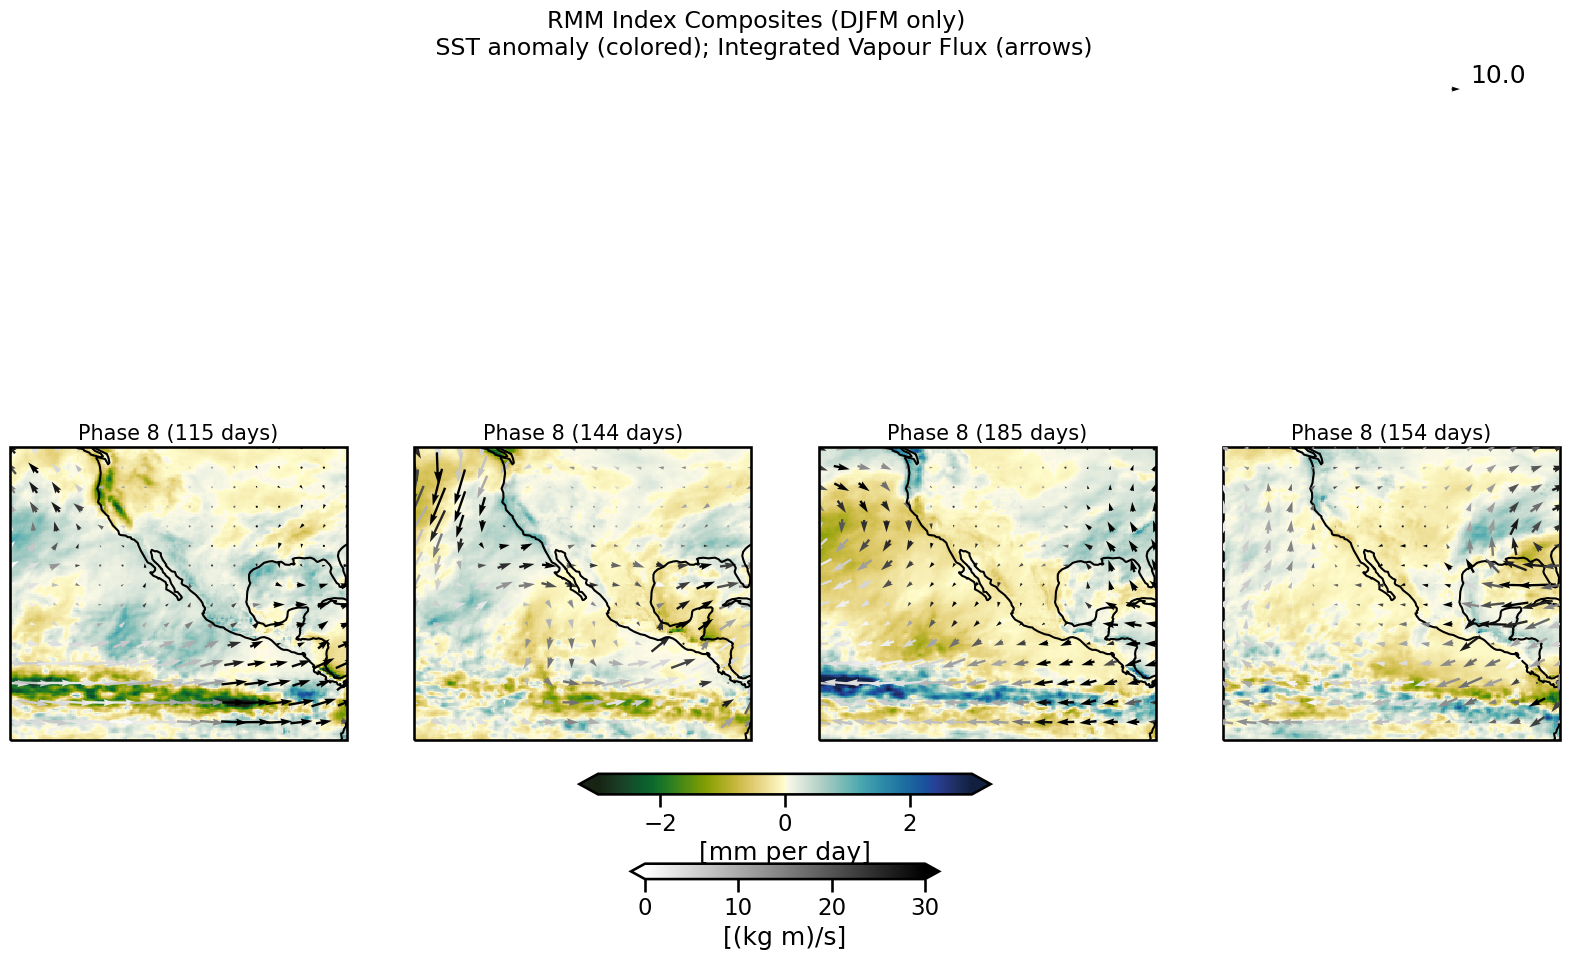

In [32]:
fig, axes = plt.subplots(ncols = 4, nrows = 1, figsize = (20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
z500_levels = np.arange(-0.4, 0.41, 0.1) 
# fig.tight_layout()
[ax.coastlines() for ax in axes.flatten()];

fig.suptitle("RMM Index Composites (DJFM only) \n SST anomaly (colored); Integrated Vapour Flux (arrows)", fontsize = 17)

for (i, phase) in enumerate(["18", "23", "45", "67"]):
    # phase_num = int(phase) - 1; i = phase_num
    ax = axes.flatten(order = "C")[i]
    IVT = prepare_IVTE_and_IVTN(combine_DJF_phases, phase)

    if phase != "67":
        IVT = prepare_IVTE_and_IVTN(combine_DJF_phases, phase)
        combine_DJF_phases["Precip"][phase].sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80)).plot(ax = ax, cmap = cm.delta_r,transform = ccrs.PlateCarree(),
                                                                                              vmin = -3, vmax = 3, add_colorbar = False)
        IVT.plot.quiver(ax = ax, x = "longitude", y = "latitude",u = "IVTE", v = "IVTN", hue = "IVT", transform=ccrs.PlateCarree(),
                    add_guide = False, cmap = "gist_yarg", width = 0.007, vmin = 0, vmax = 30)

        ax.set_title("Phase " + str(phase_num+1) + " (" + str(len(phases_dict[str(i+1)])) + " days)", fontsize = 15)

        # ax.clabel(cs, inline=True, fontsize=10)
    else:
        IVT = prepare_IVTE_and_IVTN(combine_DJF_phases, phase)
        IVT.plot.quiver(ax = ax, x = "longitude", y = "latitude",u = "IVTE", v = "IVTN", hue = "IVT", transform=ccrs.PlateCarree(),
            add_guide = True, cmap = "gist_yarg", width = 0.007, vmin = 0, vmax = 30, zorder=10,
                    cbar_kwargs = {"label":"[(kg m)/s]", "extend": "both",  "orientation":"horizontal", "ax":axes, "fraction":0.02, "pad":0.09})
        combine_DJF_phases["Precip"][phase].sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80)).plot(ax = ax, cmap = cm.delta_r,transform = ccrs.PlateCarree(),
                                                                                              vmin = -3, vmax = 3, add_colorbar = True,zorder=0, 
                                                                                               cbar_kwargs = {"label":"[mm per day]", "extend": "both", 
                                                                                                              "orientation":"horizontal", "ax":axes,
                                                                                                             "fraction":0.03, "pad":0.05})

        
        ax.set_title("Phase " + str(phase_num+1) + " (" + str(len(phases_dict[str(i+1)])) + " days)", fontsize = 15)

# for (i, ax) in enumerate(axes[:, 0].flatten()):
#     gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                       linewidth=1, color='gray', alpha=0.0, linestyle='--')
#     gl.top_labels = False
#     gl.bottom_labels = False
#     gl.right_labels = False
    
    
# for (i, ax) in enumerate(axes[1, :].flatten()):
#     gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                       linewidth=1, color='gray', alpha=0.0, linestyle='--')
#     gl.top_labels = False
#     gl.right_labels = False
#     gl.left_labels = False
# [ax.coastlines() for ax in axes.flatten()];

    
# fig.savefig(plotsdir(INDEX_TYPE + "_Index_Precip_IVT_CompositesDJF.png"), bbox_inches = "tight")

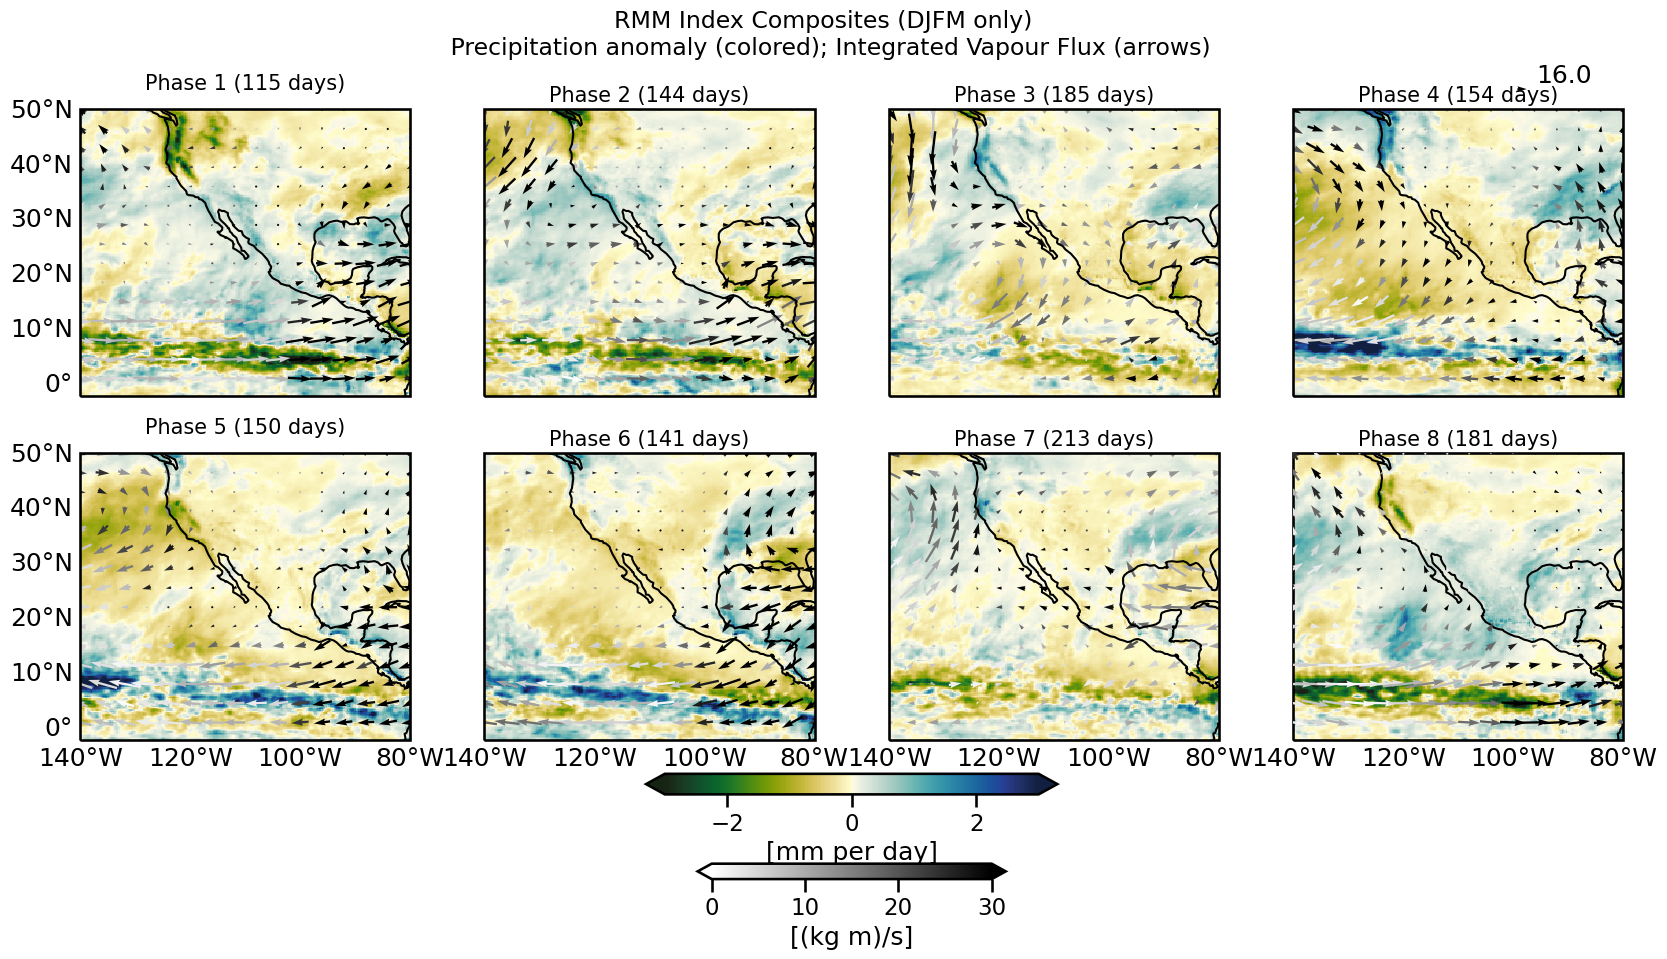

In [8]:
fig, axes = plt.subplots(ncols = 4, nrows = 2, figsize = (20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
z500_levels = np.arange(-0.4, 0.41, 0.1) 
# fig.tight_layout()

fig.suptitle("RMM Index Composites (DJFM only) \n Precipitation anomaly (colored); Integrated Vapour Flux (arrows)", fontsize = 17)

for phase, phase_indices in phases_dict.items():
    phase_num = int(phase) - 1; i = phase_num
    ax = axes.flatten(order = "C")[phase_num]

    if phase != "8":
        IVT = prepare_IVTE_and_IVTN(DJF_phases, phase)
        DJF_phases["Precip"][phase].sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80)).plot(ax = ax, cmap = cm.delta_r,transform = ccrs.PlateCarree(),
                                                                                              vmin = -3, vmax = 3, add_colorbar = False)
        IVT.plot.quiver(ax = ax, x = "longitude", y = "latitude",u = "IVTE", v = "IVTN", hue = "IVT", transform=ccrs.PlateCarree(),
                    add_guide = False, cmap = "gist_yarg", width = 0.007, vmin = 0, vmax = 30)

        ax.set_title("Phase " + str(phase_num+1) + " (" + str(len(phases_dict[str(i+1)])) + " days)", fontsize = 15)

        # ax.clabel(cs, inline=True, fontsize=10)
    else:
        IVT = prepare_IVTE_and_IVTN(DJF_phases, phase)
        IVT.plot.quiver(ax = ax, x = "longitude", y = "latitude",u = "IVTE", v = "IVTN", hue = "IVT", transform=ccrs.PlateCarree(),
            add_guide = True, cmap = "gist_yarg", width = 0.007, vmin = 0, vmax = 30, zorder=10,
                    cbar_kwargs = {"label":"[(kg m)/s]", "extend": "both",  "orientation":"horizontal", "ax":axes, "fraction":0.02, "pad":0.09})
        DJF_phases["Precip"][phase].sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80)).plot(ax = ax, cmap = cm.delta_r,transform = ccrs.PlateCarree(),
                                                                                              vmin = -3, vmax = 3, add_colorbar = True,zorder=0, 
                                                                                               cbar_kwargs = {"label":"[mm per day]", "extend": "both", 
                                                                                                              "orientation":"horizontal", "ax":axes,
                                                                                                             "fraction":0.03, "pad":0.05})

        
        ax.set_title("Phase " + str(phase_num+1) + " (" + str(len(phases_dict[str(i+1)])) + " days)", fontsize = 15)

for (i, ax) in enumerate(axes[:, 0].flatten()):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.0, linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    
    
for (i, ax) in enumerate(axes[1, :].flatten()):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.0, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
[ax.coastlines() for ax in axes.flatten()];

    
fig.savefig(plotsdir(INDEX_TYPE + "_Index_Precip_IVT_CompositesDJF.png"), bbox_inches = "tight")

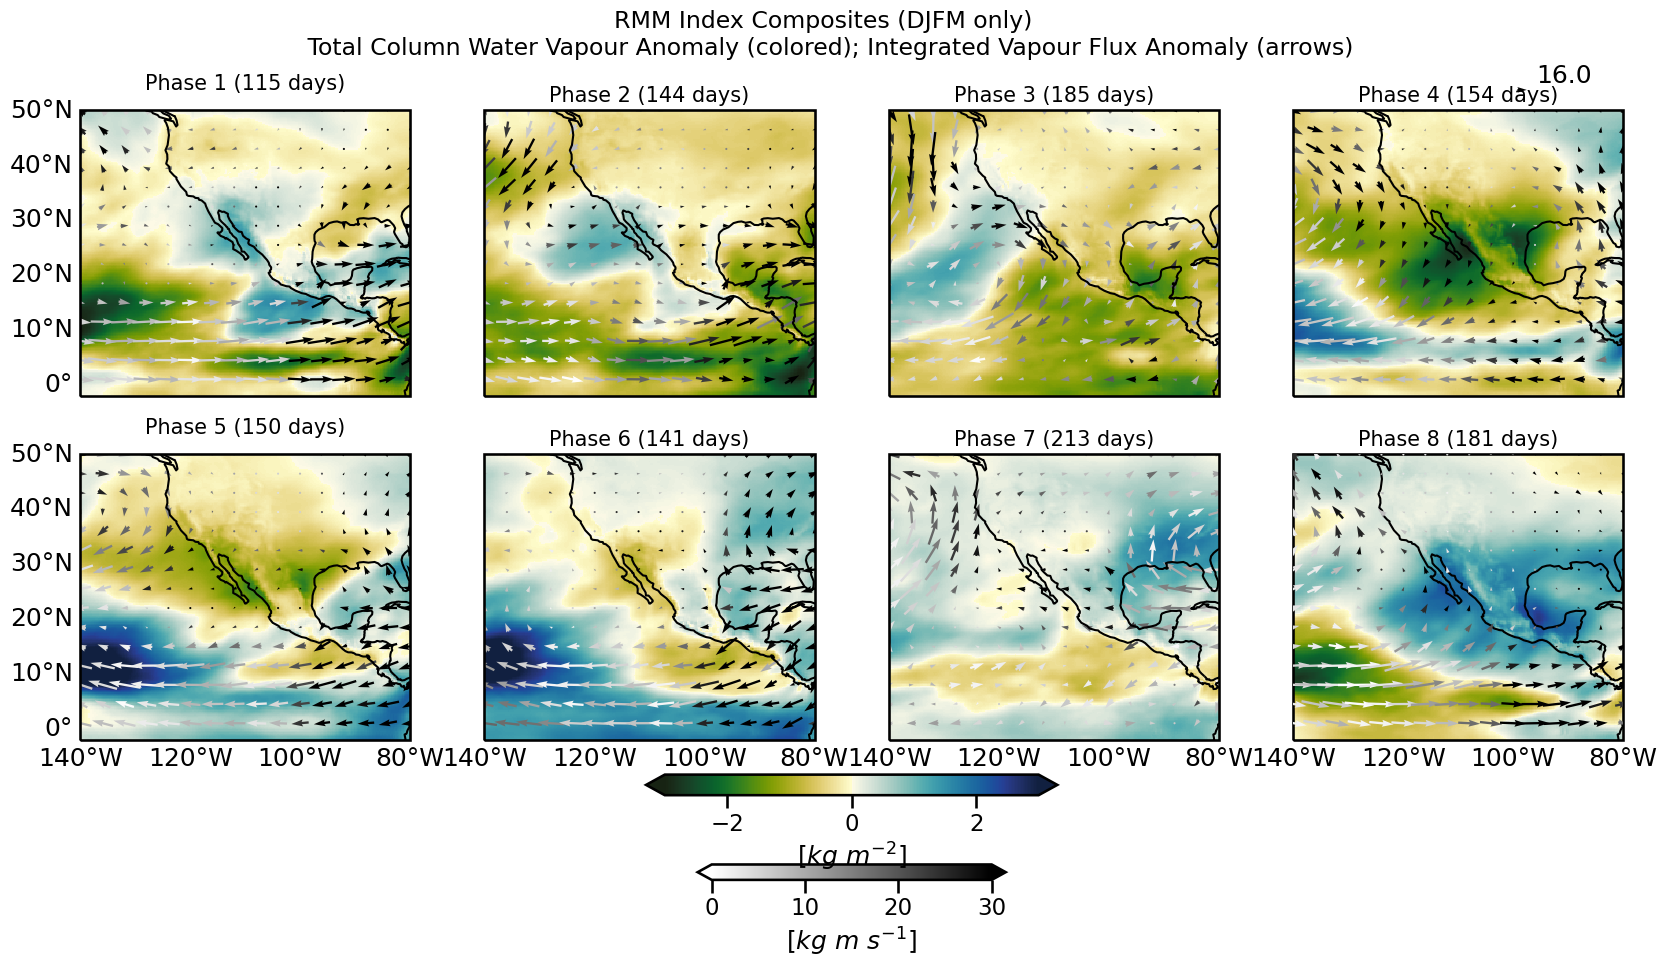

In [9]:
fig, axes = plt.subplots(ncols = 4, nrows = 2, figsize = (20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
z500_levels = np.arange(-0.4, 0.41, 0.1) 
# fig.tight_layout()
[ax.coastlines() for ax in axes.flatten()];

fig.suptitle("RMM Index Composites (DJFM only) \n Total Column Water Vapour Anomaly (colored); Integrated Vapour Flux Anomaly (arrows)", fontsize = 17)

for phase, phase_indices in phases_dict.items():
    phase_num = int(phase) - 1; i = phase_num
    ax = axes.flatten(order = "C")[phase_num]
    IVT = prepare_IVTE_and_IVTN(DJF_phases, phase)

    if phase != "8":
        DJF_phases["TCWV"][phase].sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80)).plot(ax = ax, cmap = cm.delta_r,transform = ccrs.PlateCarree(),
                                                                                              vmin = -3, vmax = 3, add_colorbar = False)
        IVT.plot.quiver(ax = ax, x = "longitude", y = "latitude",u = "IVTE", v = "IVTN", hue = "IVT", transform=ccrs.PlateCarree(),
                    add_guide = False, cmap = "gist_yarg", width = 0.007, vmin = 0, vmax = 30)

        ax.set_title("Phase " + str(phase_num+1) + " (" + str(len(phases_dict[str(i+1)])) + " days)", fontsize = 15)

        # ax.clabel(cs, inline=True, fontsize=10)
    else:
        IVT.plot.quiver(ax = ax, x = "longitude", y = "latitude",u = "IVTE", v = "IVTN", hue = "IVT", transform=ccrs.PlateCarree(),
            add_guide = True, cmap = "gist_yarg", width = 0.007, vmin = 0, vmax = 30, zorder=10,
                    cbar_kwargs = {"label":"[$kg ~ m ~ s^{-1}$]", "extend": "both",  "orientation":"horizontal", "ax":axes, "fraction":0.02, "pad":0.09})
        DJF_phases["TCWV"][phase].sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80)).plot(ax = ax, cmap = cm.delta_r,transform = ccrs.PlateCarree(),
                                                                                              vmin = -3, vmax = 3, add_colorbar = True, zorder=0,
                                                                                               cbar_kwargs = {"label":r"[$kg ~ m^{-2}$]", "extend": "both", 
                                                                                                              "orientation":"horizontal", "ax":axes,
                                                                                                             "fraction":0.03, "pad":0.05})

        
        ax.set_title("Phase " + str(phase_num+1) + " (" + str(len(phases_dict[str(i+1)])) + " days)", fontsize = 15)
        # ax.clabel(cs, inline=True, fontsize=10)

for (i, ax) in enumerate(axes[:, 0].flatten()):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.0, linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    
    
for (i, ax) in enumerate(axes[1, :].flatten()):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.0, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False

    
fig.savefig(plotsdir(INDEX_TYPE + "_Index_TCWV_IVT_CompositesDJF.png"), bbox_inches = "tight")

## Overlaying the z500 height anomaly contours on SST 

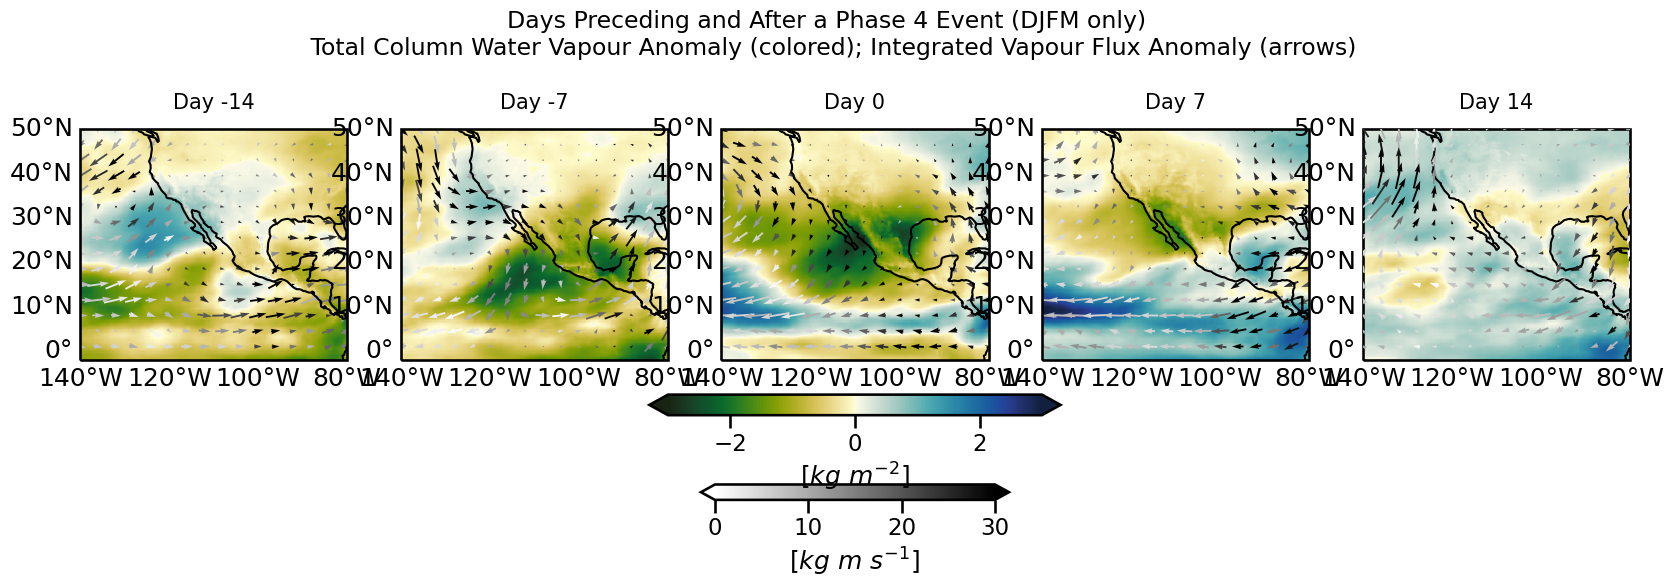

In [10]:
fig, axes = plt.subplots(ncols = 5, nrows = 1, figsize = (20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
z500_levels = np.arange(-0.4, 0.41, 0.1) 
# fig.tight_layout()

fig.suptitle("Days Preceding and After a Phase 4 Event (DJFM only) \n Total Column Water Vapour Anomaly (colored); Integrated Vapour Flux Anomaly (arrows)", y = 0.6, fontsize = 17)

phase_indices = phases_dict[phase]
num_phases_days = len(phase_indices)
for day_num, day in enumerate([-14, -7, 0, 7, 14]):
    ax = axes.flatten(order = "C")[day_num]
    IVT = prepare_IVTE_and_IVTN(DJF_phase4_dict).sel(day = day)
    if day != 14:
        DJF_phase4_dict["TCWV"].sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80), day = day).plot(ax = ax, cmap = cm.delta_r,transform = ccrs.PlateCarree(),
                                                                                              vmin = -3.0, vmax = 3.0, add_colorbar = False)

        IVT.plot.quiver(ax = ax, x = "longitude", y = "latitude",u = "IVTE", v = "IVTN", hue = "IVT", transform=ccrs.PlateCarree(),
                    add_guide = False, cmap = "gist_yarg", width = 0.007, vmin = 0, vmax = 30)
        ax.set_title("Day " + str(day), fontsize = 15)
    else:
        IVT.plot.quiver(ax = ax, x = "longitude", y = "latitude",u = "IVTE", v = "IVTN", hue = "IVT", transform=ccrs.PlateCarree(),
            add_guide = True, cmap = "gist_yarg", width = 0.007, vmin = 0, vmax = 30, zorder=10,
                    cbar_kwargs = {"label":"[$kg ~ m ~ s^{-1}$]", "extend": "both",  "orientation":"horizontal", "ax":axes, "fraction":0.02, "pad":0.09})
        DJF_phase4_dict["TCWV"].sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80), day = day).plot(ax = ax, cmap = cm.delta_r,transform = ccrs.PlateCarree(),
                                                                                              vmin = -3.0, vmax = 3.0, add_colorbar = True,
                                                                                               cbar_kwargs = {"label":"[$kg ~ m^{-2}$]", "extend": "both", 
                                                                                                              "orientation":"horizontal", "ax":axes,
                                                                                                             "fraction":0.03, "pad":0.05})

        ax.set_title("Day " + str(day), fontsize = 15)


for (i, ax) in enumerate(axes.flatten()):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.0, linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    
    
for (i, ax) in enumerate(axes.flatten()):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.0, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False

    
[ax.coastlines() for ax in axes.flatten()];
fig.savefig(plotsdir(INDEX_TYPE + "_Index_Phase4_TCWV_IVT_CompositesDJF.png"), bbox_inches = "tight")

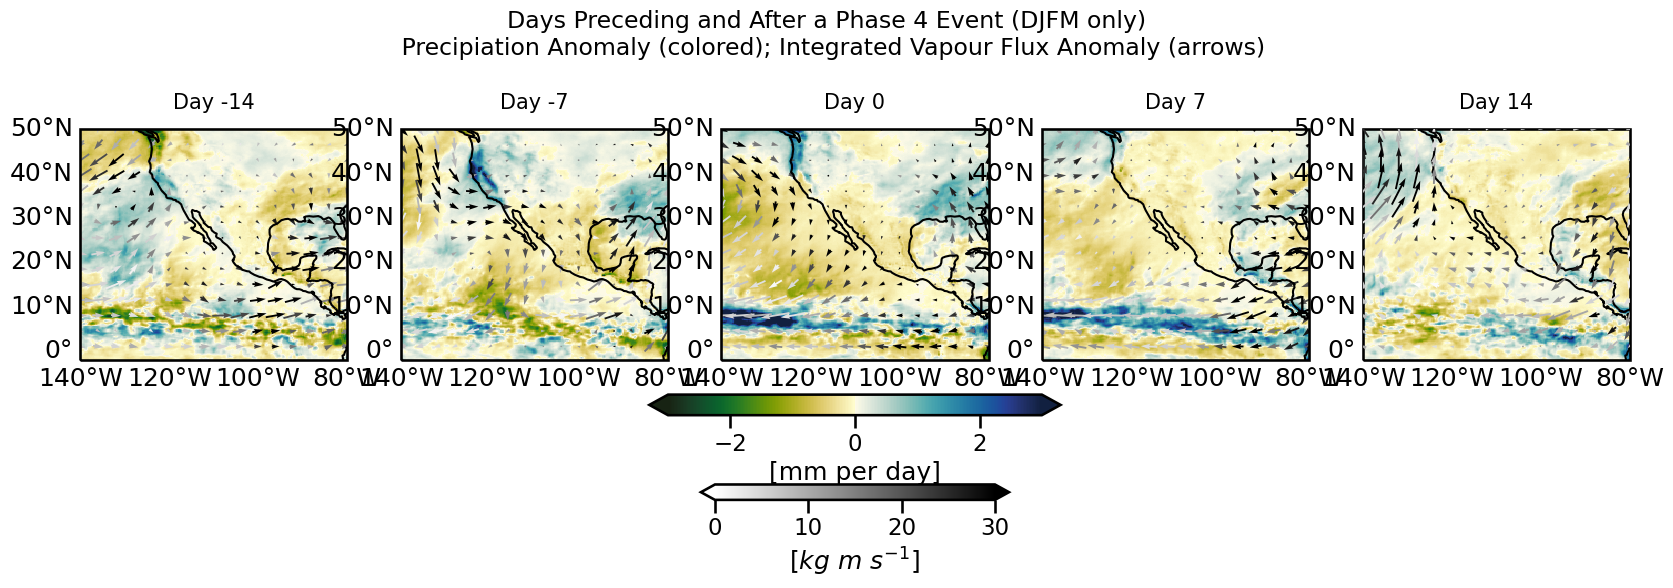

In [11]:
fig, axes = plt.subplots(ncols = 5, nrows = 1, figsize = (20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
z500_levels = np.arange(-0.4, 0.41, 0.1) 
# fig.tight_layout()

fig.suptitle("Days Preceding and After a Phase 4 Event (DJFM only) \n Precipiation Anomaly (colored); Integrated Vapour Flux Anomaly (arrows)", y = 0.6, fontsize = 17)

phase_indices = phases_dict[phase]
num_phases_days = len(phase_indices)
for day_num, day in enumerate([-14, -7, 0, 7, 14]):
    ax = axes.flatten(order = "C")[day_num]
    IVT = prepare_IVTE_and_IVTN(DJF_phase4_dict).sel(day = day)
    if day != 14:
        DJF_phase4_dict["Precip"].sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80), day = day).plot(ax = ax, cmap = cm.delta_r,transform = ccrs.PlateCarree(),
                                                                                              vmin = -3.0, vmax = 3.0, add_colorbar = False)

        IVT.plot.quiver(ax = ax, x = "longitude", y = "latitude",u = "IVTE", v = "IVTN", hue = "IVT", transform=ccrs.PlateCarree(),
                    add_guide = False, cmap = "gist_yarg", width = 0.007, vmin = 0, vmax = 30)
        ax.set_title("Day " + str(day), fontsize = 15)
    else:
        IVT.plot.quiver(ax = ax, x = "longitude", y = "latitude",u = "IVTE", v = "IVTN", hue = "IVT", transform=ccrs.PlateCarree(),
        add_guide = True, cmap = "gist_yarg", width = 0.007, vmin = 0, vmax = 30, zorder=10,
                    cbar_kwargs = {"label":"[$kg ~ m ~ s^{-1}$]", "extend": "both",  "orientation":"horizontal", "ax":axes, "fraction":0.02, "pad":0.09})
        DJF_phase4_dict["Precip"].sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80), day = day).plot(ax = ax, cmap = cm.delta_r,transform = ccrs.PlateCarree(),
                                                                                              vmin = -3.0, vmax = 3.0, add_colorbar = True,
                                                                                               cbar_kwargs = {"label":"[mm per day]", "extend": "both", 
                                                                                                              "orientation":"horizontal", "ax":axes,
                                                                                                             "fraction":0.03, "pad":0.05})

        ax.set_title("Day " + str(day), fontsize = 15)


for (i, ax) in enumerate(axes.flatten()):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.0, linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    
    
for (i, ax) in enumerate(axes.flatten()):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.0, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False

    
[ax.coastlines() for ax in axes.flatten()];
fig.savefig(plotsdir(INDEX_TYPE + "_Index_Phase4_PRCP_IVT_CompositesDJF.png"), bbox_inches = "tight")

TypeError: No numeric data to plot.

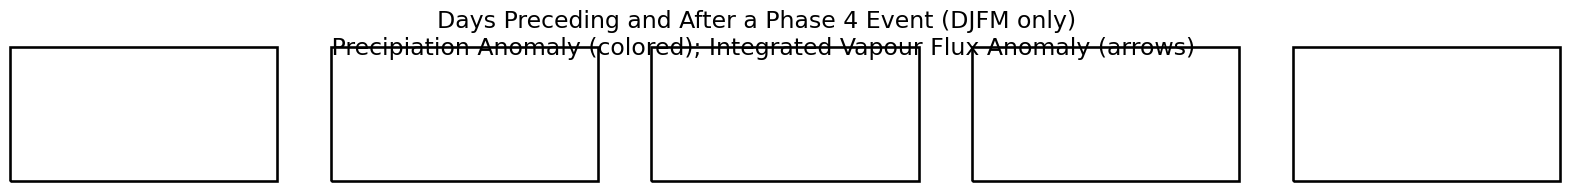

In [12]:
fig, axes = plt.subplots(ncols = 5, nrows = 1, figsize = (20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
z500_levels = np.arange(-0.4, 0.41, 0.1) 
# fig.tight_layout()

fig.suptitle("Days Preceding and After a Phase 4 Event (DJFM only) \n Precipiation Anomaly (colored); Integrated Vapour Flux Anomaly (arrows)", y = 0.6, fontsize = 17)

phase_indices = phases_dict[phase]
num_phases_days = len(phase_indices)
for day_num, day in enumerate([-14, -7, 0, 7, 14]):
    ax = axes.flatten(order = "C")[day_num]
    IVT = prepare_IVTE_and_IVTN(DJF_phase4_dict).sel(day = day)
    if day != 14:
        DJF_phase4_dict["SST"].sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80), day = day).plot(ax = ax, cmap = cm.delta_r,transform = ccrs.PlateCarree(),
                                                                                              vmin = -3.0, vmax = 3.0, add_colorbar = False)

        IVT.plot.quiver(ax = ax, x = "longitude", y = "latitude",u = "IVTE", v = "IVTN", hue = "IVT", transform=ccrs.PlateCarree(),
                    add_guide = False, cmap = "gist_yarg", width = 0.007, vmin = 0, vmax = 30)
        ax.set_title("Day " + str(day), fontsize = 15)
    else:
        IVT.plot.quiver(ax = ax, x = "longitude", y = "latitude",u = "IVTE", v = "IVTN", hue = "IVT", transform=ccrs.PlateCarree(),
        add_guide = True, cmap = "gist_yarg", width = 0.007, vmin = 0, vmax = 30, zorder=10,
                    cbar_kwargs = {"label":"[$kg ~ m ~ s^{-1}$]", "extend": "both",  "orientation":"horizontal", "ax":axes, "fraction":0.02, "pad":0.09})
        DJF_phase4_dict["SST"].sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80), day = day).plot(ax = ax, cmap = cm.delta_r,transform = ccrs.PlateCarree(),
                                                                                              vmin = -3.0, vmax = 3.0, add_colorbar = True,
                                                                                               cbar_kwargs = {"label":"[mm per day]", "extend": "both", 
                                                                                                              "orientation":"horizontal", "ax":axes,
                                                                                                             "fraction":0.03, "pad":0.05})

        ax.set_title("Day " + str(day), fontsize = 15)


for (i, ax) in enumerate(axes.flatten()):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.0, linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    
    
for (i, ax) in enumerate(axes.flatten()):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.0, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False

    
[ax.coastlines() for ax in axes.flatten()];
fig.savefig(plotsdir(INDEX_TYPE + "_Index_Phase4_PRCP_IVT_CompositesDJF.png"), bbox_inches = "tight")

In [ ]:
# fig, axes = plt.subplots(ncols = 5, nrows = 8, figsize = (15, 40), subplot_kw={'projection': ccrs.PlateCarree()})
# fig.suptitle("Composites using Mixed Layer Temperature and SSH Coastal Wave Index (DJFM only)", y = 0.8, fontsize = 15)
# for phase, phase_indices in phases_dict.items():
#     print(phase)
#     phase_num = int(phase) - 1 
#     IVT = prepare_IVTE_and_IVTN(DJF_phases, phase)
#     if phase != "8":
#         DJF_phases["SST"][phase].sel(latitude = slice(-2, 50), longitude = slice(-140, -80)).plot(ax = axes[phase_num, 0], cmap = cm.balance,transform=ccrs.PlateCarree(),
#                                                                                               vmin = -0.5, vmax = 0.5, add_colorbar = False)
#         DJF_phases["Precip"][phase].sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80)).plot(ax = axes[phase_num, 1], cmap = cm.balance,transform=ccrs.PlateCarree(),
#                                                                                               vmin = -2.0, vmax = 2.0, add_colorbar = False)
#         DJF_phases["TCWV"][phase].sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80)).plot(ax = axes[phase_num, 2], cmap = cm.balance,transform=ccrs.PlateCarree(),
#                                                                                               vmin = -2.5, vmax = 2.5, add_colorbar = False)
#         DJF_phases["z500"][phase].sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80)).plot(ax = axes[phase_num, 3], cmap = cm.balance,transform=ccrs.PlateCarree(),
#                                                                                               vmin = -0.4, vmax = 0.4, add_colorbar = False)
#         IVT.plot.quiver(ax = axes[phase_num, 4], x = "longitude", y = "latitude",u = "IVTE", v = "IVTN", hue = "IVT", transform=ccrs.PlateCarree(),
#                     add_guide = False, cmap = "Greens", vmin = -0, vmax = 50, width = 0.009)
#         fig.tight_layout()
#     else:
#         DJF_phases["SST"][phase].sel(latitude = slice(-2, 50), longitude = slice(-140, -80)).plot(ax = axes[phase_num, 0], cmap = cm.balance,
#                                                                                               vmin = -0.5, vmax = 0.5, add_colorbar = True,transform=ccrs.PlateCarree(),
#                                                                                                cbar_kwargs = {"label":"[°C]", "extend": "both", 
#                                                                                                               "orientation":"horizontal", "ax":axes[:, 0],
#                                                                                                              "fraction":0.04, "pad":0.01})
#         DJF_phases["Precip"][phase].sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80)).plot(ax = axes[phase_num, 1], cmap = cm.balance,
#                                                                                               vmin = -2.0, vmax = 2.0, add_colorbar = True,transform=ccrs.PlateCarree(),
#                                                                                                cbar_kwargs = {"label":"[mm/day]", "extend": "both", 
#                                                                                                               "orientation":"horizontal", "ax":axes[:, 1],
#                                                                                                              "fraction":0.04, "pad":0.01})
#         DJF_phases["TCWV"][phase].sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80)).plot(ax = axes[phase_num, 2], cmap = cm.balance,
#                                                                                               vmin = -2.5, vmax = 2.5, add_colorbar = True,transform=ccrs.PlateCarree(),
#                                                                                                cbar_kwargs = {"label":"[kg/m^3]", "extend": "both", 
#                                                                                                               "orientation":"horizontal", "ax":axes[:, 2],
#                                                                                                               "fraction":0.04, "pad":0.01})
#         DJF_phases["z500"][phase].sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80)).plot(ax = axes[phase_num, 3], cmap = cm.balance,
#                                                                                               vmin = -0.4, vmax = 0.4, add_colorbar = True,transform=ccrs.PlateCarree(),
#                                                                                                cbar_kwargs = {"label":"[km]", "extend": "both", 
#                                                                                                               "orientation":"horizontal", "ax":axes[:, 3],
#                                                                                                               "fraction":0.04, "pad":0.01})  
#         IVT.plot.quiver(ax = axes[phase_num, 4], x = "longitude", y = "latitude",u = "IVTE", v = "IVTN", hue = "IVT", transform=ccrs.PlateCarree(),
#                     add_guide = True, cmap = "Greens", vmin = 0, vmax = 50, width = 0.009, 
#                     cbar_kwargs = {"label":"[(kg m)/s]", "extend": "both",  "orientation":"horizontal", "ax":axes[:, 4], "fraction":0.04, "pad":0.01})

# [ax.set_title("") for ax in axes.flatten()];
# [ax.set_title("SST Anomaly") for ax in axes[:, 0].flatten()]
# [ax.set_title("Total Precipiation \n Anomaly") for ax in axes[:, 1].flatten()]
# [ax.set_title("Total Column Water \n Vapor Anomaly") for ax in axes[:, 2].flatten()]
# [ax.set_title("z500 Height Anomaly") for ax in axes[:, 3].flatten()]
# [ax.set_title("Vertical Integral of \n Water Vapour Flux") for ax in axes[:, 4].flatten()]


# for (i, ax) in enumerate(axes[:, 0].flatten()):
#     gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                       linewidth=1, color='gray', alpha=0.0, linestyle='--')
#     gl.top_labels = False
#     gl.bottom_labels = False
#     gl.right_labels = False
    
#     ax.text(-0.3, 0.55, "Phase " + str(i+1) + " (" + str(len(phases_dict[str(i+1)])) + " days)", fontsize = 15, va='bottom', ha='center',
#         rotation='vertical', rotation_mode='anchor',
#         transform=ax.transAxes)
    
# [ax.coastlines() for ax in axes.flatten()];
